In [1]:
# Imports.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from data_utils import CSVData
from dynamical_systems import linear_system, andronov_hopf
from nets import EulerN
from torch.utils.data.sampler import SubsetRandomSampler
from utils import euler, plot_phase_portrait, train_valid_loader

# 1. Linear system.

In [2]:
# Choose your network parameters.
input_size=2
num_param=1
hidden_size=20
h=1

# Initialise the model.
model = EulerN(input_size, num_param, hidden_size, h)

In [3]:
# Load data.
dataset = CSVData(csv_file_path='first_model.csv')
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [4]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)


for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.063209444
[1,  4000] loss: 0.000065468
[1,  6000] loss: 0.000030468
[1,  8000] loss: 0.000018951
[1, 10000] loss: 0.000013157
[2,  2000] loss: 0.000010350
[2,  4000] loss: 0.000010094
[2,  6000] loss: 0.000011197
[2,  8000] loss: 0.000013600
[2, 10000] loss: 0.000011630
[3,  2000] loss: 0.000011212
[3,  4000] loss: 0.000010042
[3,  6000] loss: 0.000008243
[3,  8000] loss: 0.000007701
[3, 10000] loss: 0.000007926
[4,  2000] loss: 0.000007590
[4,  4000] loss: 0.000006546
[4,  6000] loss: 0.000005708
[4,  8000] loss: 0.000004937
[4, 10000] loss: 0.000004533
[5,  2000] loss: 0.000004356
[5,  4000] loss: 0.000004353
[5,  6000] loss: 0.000004480
[5,  8000] loss: 0.000004622
[5, 10000] loss: 0.000004714
[6,  2000] loss: 0.000004618
[6,  4000] loss: 0.000004177
[6,  6000] loss: 0.000003927
[6,  8000] loss: 0.000003852
[6, 10000] loss: 0.000003796
[7,  2000] loss: 0.000003753
[7,  4000] loss: 0.000003711
[7,  6000] loss: 0.000003628
[7,  8000] loss: 0.000003510
[7, 10000] los

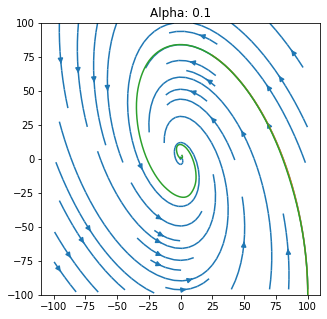

In [5]:
alpha = 0.1

plot_phase_portrait(linear_system, alpha, model, 100)

# 2. Andronov-Hopf system

In [6]:
h = 1

hss = [100]
bss = [1000]
lrs = [0.001]
wds = [0]
nhls = [3]
epochs = 10

validation_split = .2
random_seed = 42


for bs in bss:
    dataset = CSVData(csv_file_path='second_model.csv')    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=bs, sampler=train_sampler)
    valid_loader = DataLoader(dataset, batch_size=bs, sampler=valid_sampler)
    
    for hs in hss:
        for lr in lrs:
            for wd in wds:
                for nhl in nhls:
                    print('-----------------------------------------------------------')
                    print('bs=' + str(bs), 'hs=' + str(hs), 'lr=' + str(lr), 
                          'wd=' + str(wd), 'nhl=' + str(nhl))
                    model = EulerN(2, 1, hs, h, nhl)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    
                    for epoch in range(epochs):  # loop over the dataset multiple times
                        running_loss = 0.0
                        for i, data in enumerate(train_loader, 0):
                            # get the inputs; data is a list of [inputs, labels]
                            inputs, params, labels = data
                            
                            # zero the parameter gradients
                            optimizer.zero_grad()

                            # forward + backward + optimize
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                            # print statistics
                            running_loss += loss.item()
                            if i % 200 == 199:    # print every 2000 mini-batches
                                print('[%2d, %4d] loss: %.15f' %
                                        (epoch + 1, i + 1, running_loss / 200))
                                running_loss = 0.0
                                
                    print('Finished Training')
                        
                        
                    with torch.no_grad():
                        train_loss = 0.0
                        valid_loss = 0.0
                        criterion = nn.MSELoss()
                            
                        for data in train_loader:
                            inputs, params, labels = data
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            train_loss += loss.item()
                                                        
                        for data in valid_loader:
                            inputs, params, labels = data
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            valid_loss += loss.item()
                                
                        train_loss /= len(train_loader)
                        valid_loss /= len(valid_loader)
                                                        
                        print('Train loss: %.15f' % (train_loss,))
                        print('Valid loss: %.15f' % (valid_loss,))

-----------------------------------------------------------
bs=1000 hs=100 lr=0.001 wd=0 nhl=3
[ 1,  200] loss: 0.000134897409780
[ 1,  400] loss: 0.000036598643107
[ 1,  600] loss: 0.000025938529411
[ 1,  800] loss: 0.000020318368506
[ 1, 1000] loss: 0.000015579461677
[ 1, 1200] loss: 0.000017574577560
[ 1, 1400] loss: 0.000014348665061
[ 1, 1600] loss: 0.000009843171617
[ 1, 1800] loss: 0.000011937335878
[ 1, 2000] loss: 0.000009811275312
[ 1, 2200] loss: 0.000007696116659
[ 1, 2400] loss: 0.000007517530798
[ 1, 2600] loss: 0.000007039884267
[ 1, 2800] loss: 0.000005090430357
[ 1, 3000] loss: 0.000006134002566
[ 1, 3200] loss: 0.000005390764143
[ 1, 3400] loss: 0.000004882160695
[ 1, 3600] loss: 0.000005545772977
[ 1, 3800] loss: 0.000004676437038
[ 1, 4000] loss: 0.000004091055697
[ 1, 4200] loss: 0.000003946492363
[ 1, 4400] loss: 0.000004892942949
[ 1, 4600] loss: 0.000003205866725
[ 1, 4800] loss: 0.000002973100695
[ 1, 5000] loss: 0.000002719809073
[ 1, 5200] loss: 0.00000316710

[ 6, 7600] loss: 0.000000464965365
[ 6, 7800] loss: 0.000000545683945
[ 7,  200] loss: 0.000000519863027
[ 7,  400] loss: 0.000000570873516
[ 7,  600] loss: 0.000000568690705
[ 7,  800] loss: 0.000000493678007
[ 7, 1000] loss: 0.000000434838357
[ 7, 1200] loss: 0.000000400618003
[ 7, 1400] loss: 0.000000410810990
[ 7, 1600] loss: 0.000000824061631
[ 7, 1800] loss: 0.000000487535979
[ 7, 2000] loss: 0.000000423089021
[ 7, 2200] loss: 0.000000465710070
[ 7, 2400] loss: 0.000000450839996
[ 7, 2600] loss: 0.000000462748574
[ 7, 2800] loss: 0.000000501340114
[ 7, 3000] loss: 0.000000597182313
[ 7, 3200] loss: 0.000000535401692
[ 7, 3400] loss: 0.000000492759722
[ 7, 3600] loss: 0.000000573818108
[ 7, 3800] loss: 0.000000390404540
[ 7, 4000] loss: 0.000000414191030
[ 7, 4200] loss: 0.000000676421568
[ 7, 4400] loss: 0.000000467871108
[ 7, 4600] loss: 0.000000458880592
[ 7, 4800] loss: 0.000000528356544
[ 7, 5000] loss: 0.000000497766502
[ 7, 5200] loss: 0.000000482538334
[ 7, 5400] loss: 0.0

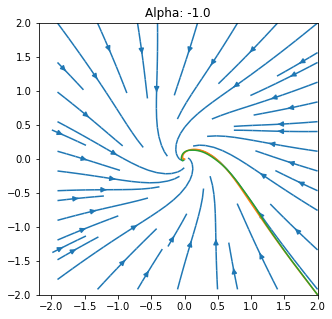

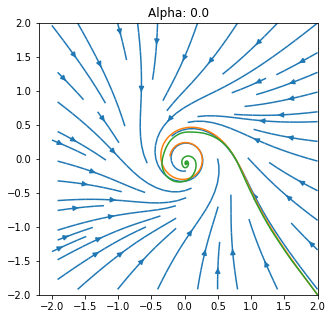

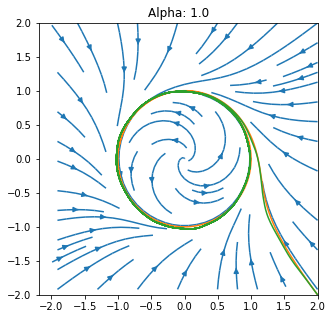

In [7]:
plot_phase_portrait(andronov_hopf, -1.0, model, 2)
plot_phase_portrait(andronov_hopf,  0.0, model, 2)
plot_phase_portrait(andronov_hopf,  1.0, model, 2)